# Filter study for Cryoscope

**Goal**: find *correct* predistortion filters to apply to flux impulse

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import special
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.signal import lfilter

from qibocal.protocols.two_qubit_interaction.cryoscope import _fit, _plot, CryoscopeData, CryoscopeType 

FULL_WAVEFORM = np.concatenate([np.zeros(10), np.ones(50), np.zeros(10)])


[Qibo 0.2.12|INFO|2024-12-04 17:41:52]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-04 17:41:52]: Loading platform dummy


**Loading data**

In [2]:
with open('savgol_data.pkl', 'rb') as file:
    data_phase = pickle.load(file)
    savgol_demod = data_phase["savgol_demod"]
    savgol_no_demod = data_phase["savgol_no_demod"]
    no_savgol_demod = data_phase["no_savgol_demod"]
    no_savgol_no_demod = data_phase["no_savgol_no_demod"]

with open('CryoscopeResults.pkl', 'rb') as file:
    data_results = pickle.load(file)
    result_svg_dem = data_results["savgol_demod"]
    result_svg_no_dem = data_results["savgol_no_demod"]
    result_no_svg_dem = data_results["no_savgol_demod"]
    result_no_svg_no_dem = data_results["no_savgol_no_demod"]

#### Reproduce rectangular impulse response

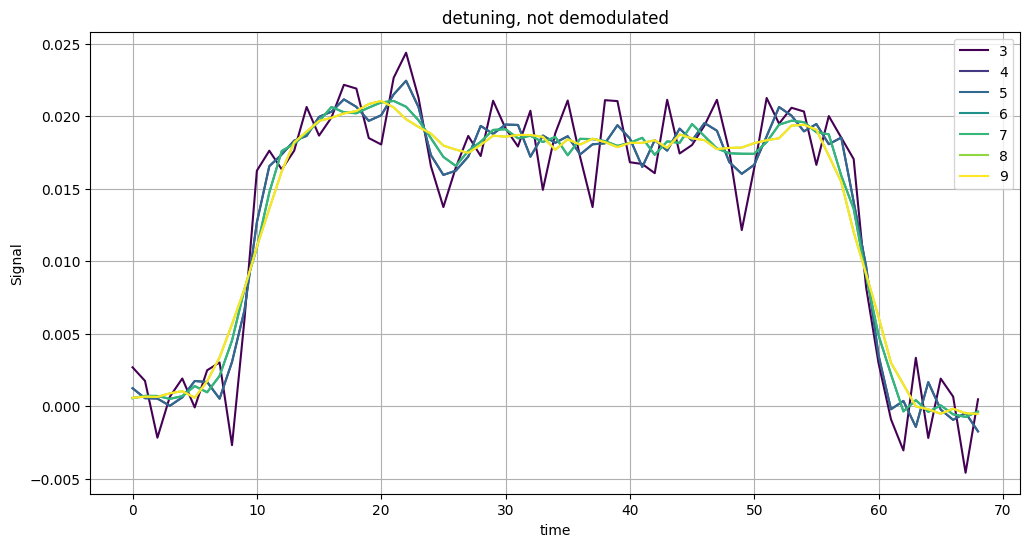

In [3]:
colors = plt.cm.viridis(np.linspace(0, 1, len(savgol_demod)))

plt.figure(figsize=(12, 6))

for i, res in enumerate(result_svg_no_dem):
    plt.plot(res.detuning["D1"], color=colors[i], label=f"{i+3}")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("detuning, not demodulated")
plt.legend()
plt.grid()
plt.show()

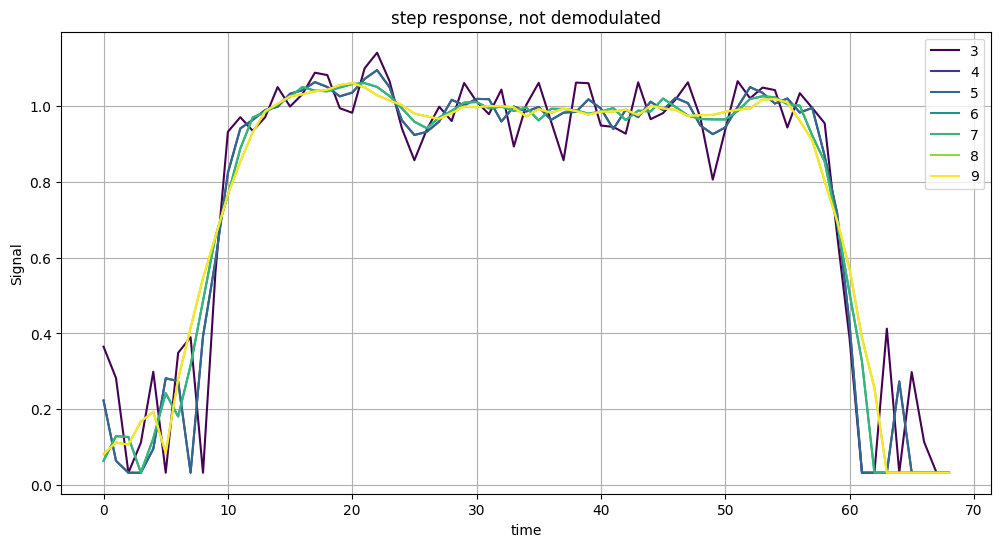

In [4]:
colors = plt.cm.viridis(np.linspace(0, 1, len(savgol_demod)))

plt.figure(figsize=(12, 6)) 

for i, res in enumerate(result_svg_no_dem):
    plt.plot(res.step_response["D1"], color = colors[i], label=f"{i+3}" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("step response, not demodulated")
plt.legend()
plt.grid()
plt.show()

### Definining filters on step function

In [5]:
def step(t):
    #return np.ones_like(t)
    return np.where(t<10, 0, 1)

In [6]:
#Filters used in the papaer for simulation

def bias_1(t, g, tau):
    return g*(np.exp((-t)/tau))*step(t)

def bias_2(t, g, tau, A):
    return g*(1 + A*np.exp(-t/tau))*step(t)

def bias_3(t, g, tau, A):
    return g*(1 + A*np.exp(-t/tau))*step(t)

def skin_effect(t, g, alpha):
    return g*(1-special.erfc(alpha*np.sqrt(t)/21))*step(t)

def on_chip(t, g, tau, A):
    return g*(1 + A*np.exp(-t/tau))*step(t)

**Minimization with least squared method from scipy**

In [7]:
def step(t):
    return np.where(t<10, 0, 1)


def model(params, t):
    g, tau, A = params
    return g*(1 + A*np.exp(-(t-10)/tau))*step(t) #exp(-(t-10)/tau)


def residuals(params, t, data):
    return model(params,t) - data


def filter(params, t):
    g, tau, A = params
    return g * (1 + A * np.exp(-(t - 10) / tau))

In [8]:
initial_guess = [1, 1, 1]
t = np.arange(0,30,1)
step_response = result_svg_no_dem[4].step_response["D1"][0:30]
print(len(step_response))

30


In [9]:
result = least_squares(residuals, initial_guess, args=(t, step_response))
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-6.405e-02 -1.287e-01 ...  2.990e-02  8.094e-03]
           x: [ 1.017e+00  1.289e+00 -2.523e-01]
        cost: 0.4652849161729139
         jac: [[ 0.000e+00  0.000e+00 -0.000e+00]
               [ 0.000e+00  0.000e+00 -0.000e+00]
               ...
               [ 1.000e+00 -2.393e-06  8.643e-07]
               [ 1.000e+00 -1.156e-06  4.023e-07]]
        grad: [ 5.202e-09  1.249e-06  5.630e-09]
  optimality: 1.2494379557925452e-06
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 6
        njev: 6


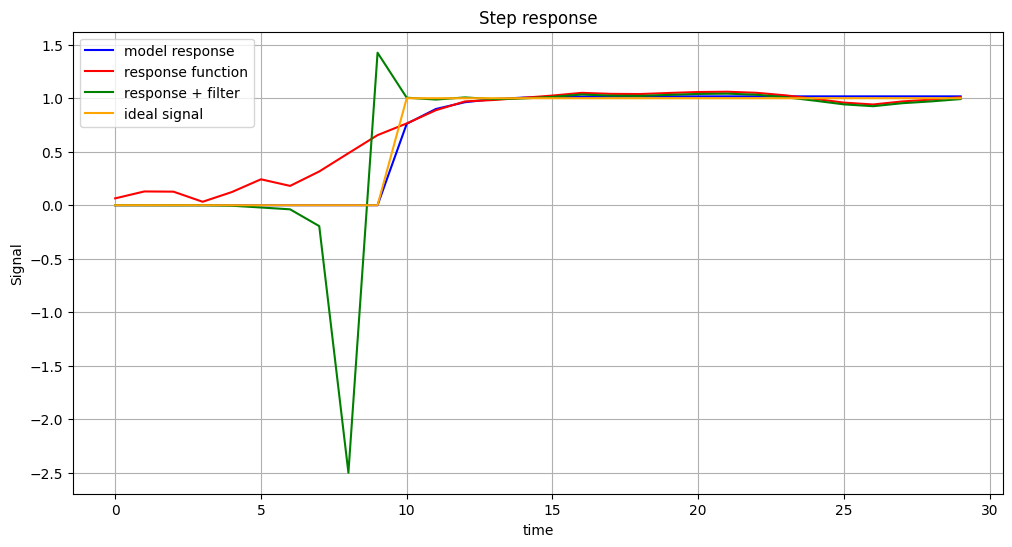

In [10]:
plt.figure(figsize=(12, 6)) 
plt.plot(t, model(result.x, t), color = "blue", label="model response")
plt.plot(step_response, color = "red", label="response function")
plt.plot(t, step_response/filter(result.x,t), color = "green", label="response + filter" )
plt.plot(t, step(t), color = "orange", label="ideal signal" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

**Risposta sollo sull'intervallo 10 - 40**

Provo ad applicare il modello (e ottimizzarlo) sulla risposta a partire dall'invio di un segnale non nullo.

NB: devo ridefinire modello e filtro perchè l'esponenziale non sia traslato, devo ridefinire anche il segnale ideal perchè in questo caso la step function è semplicemente un vettore oneslike

In [11]:
def step(t):
    return np.ones_like(t)

def model(params, t):
    g, tau, A = params
    return g * (1 + A * np.exp(-t / tau)) * step(t)  # exp(-t/tau)


def residuals(params, t, data):
    return model(params, t) - data


def filter(params, t):
    g, tau, A = params
    return g * (1 + A * np.exp(-t/ tau))

In [12]:
initial_guess = [1, 1, 1]
t = np.arange(0, 30, 1)
step_response = result_svg_no_dem[4].step_response["D1"][10:40]
print(len(step_response))

30


In [13]:
result0 = least_squares(residuals, initial_guess, args=(t, step_response))
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-6.405e-02 -1.287e-01 ...  2.990e-02  8.094e-03]
           x: [ 1.017e+00  1.289e+00 -2.523e-01]
        cost: 0.4652849161729139
         jac: [[ 0.000e+00  0.000e+00 -0.000e+00]
               [ 0.000e+00  0.000e+00 -0.000e+00]
               ...
               [ 1.000e+00 -2.393e-06  8.643e-07]
               [ 1.000e+00 -1.156e-06  4.023e-07]]
        grad: [ 5.202e-09  1.249e-06  5.630e-09]
  optimality: 1.2494379557925452e-06
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 6
        njev: 6


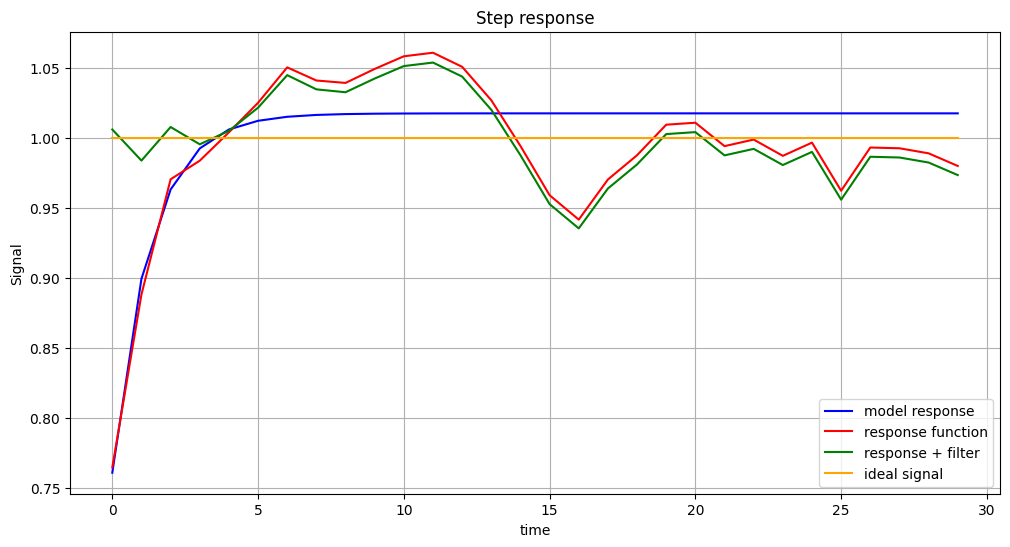

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(t, model(result.x, t), color="blue", label="model response")
plt.plot(step_response, color="red", label="response function")
plt.plot(
    t, step_response / filter(result0.x, t), color="green", label="response + filter"
)
plt.plot(t, step(t), color="orange", label="ideal signal")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [15]:
init_guess = [1, 1, 1]
results = []
responses = []

for i in range(5):
    result = least_squares(
        residuals, initial_guess, args=(t, step_response)
    )  # calcolo LSO
    results.append(result)  # immagazzino risultato
    step_response = step_response / filter(result.x, t)  # reference data update
    responses.append(step_response)  # store data at each iteration

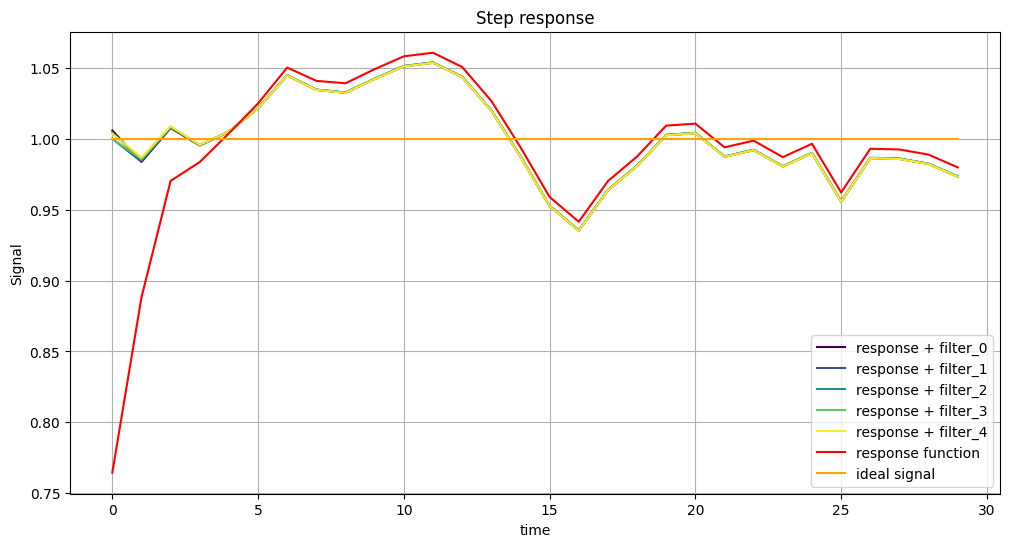

In [16]:
step_response = result_svg_no_dem[4].step_response["D1"][10:40]
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6))

for i, resp in enumerate(responses):
    plt.plot(t, resp, color=colors[i], label=f"response + filter_{i}")
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t), color="orange", label="ideal signal")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

**TO DO**:
- [X] correggere quando faccio dati/modello
- [X] studiare risposta solo su segnale non nullo
- [] valutare ordine delle oscillazioni (sto "filtrando" rumore?) Andare a vedere matrice di covarianza del fit
- [X] testare facendo l'inverso (che è quello che devo provare a fare con i FIR) 
